In [1]:
import sys
from re import split
sys.path.append('../../../')
import os
import pandas as pd
import glob
import numpy as np
from impedance.circuits import Randles, CustomCircuit
import matplotlib.pyplot as plt
from impedance.plotting import plot_nyquist
from impedance import preprocessing

In [2]:
direc=r'\\ADLERNAS\admin\BrianGerwe\Research\Data\fr-XAS\July18 Data\Versastat'

all_files=glob.glob(direc+ '\*_700C_*_EIS_*.par')
all_files.sort()

In [3]:
f_name=all_files[2]
print(f_name)
freqs, Z= preprocessing.readVersaStudio(f_name)

\\ADLERNAS\admin\BrianGerwe\Research\Data\fr-XAS\July18 Data\Versastat\LSC_DPB1_FRXAS_700C_1%_EIS_OCV_before2_Test.par


In [86]:
# Some initial guess values for all circuits
d=266e-9 #thickness of Al2O3 mask
A=3e-3*3e-3-(6*1e-3*4e-6) #Area of mask minus area of electrode gates

R_elyte=58

C_if=1.4e-6
R_if=15

C_mask=9.7*8.854e-12*8.976e-6/266e-9 #permitivity=9.7 thickness=266 nm
R_mask=3.54e5*d/A
R_chem=1600
C_chem=2.23e-4

min_ind=np.argmin(np.imag(Z[:]))
tg_init=freqs[min_ind]
Rg_init=1600

In [5]:
main_figsize=(10,7.5)
inset_figsize=(6,6)

In [77]:
def FitCirc_Plot(circ, inits, frequencies, Z_data, **kwargs):
    """ Function for fitting and plotting fit results of a defined circuit

    Parameters
    ----------
    circ : string
        string defining the equivalent circuit to be fit

    inits : list of floats
        initial guesses for the fir parameters

    frequencies : numpy array
        Frequencies

    Z_data : numpy array of dtype 'complex128'
        Impedance data to be fit

    Returns
    -------

    Notes
    -----
    Prints fitting results and displays figure of impedance data with fit
    and an inset of high frequency data of length specified by kwarg 'inset_len'
    with default value 30. Optionally saves "Main" Figure and "Inset" Figure 
    if save_figs is True and fig_name is not empty.

    """
    circuit = CustomCircuit(initial_guess = inits, circuit = circ)
    circuit.fit(frequencies, Z_data)
    print(circuit)

    pred_freq = np.logspace(np.log10(frequencies[0]), np.log10(frequencies[-1]), num = freqs.size)
    custom_fit = circuit.predict(pred_freq)

    fig1 = plt.figure(figsize = main_figsize)
    ax0 = fig1.add_subplot(211)
    plot_nyquist(ax0, freqs, Z, fmt='s')
    plot_nyquist(ax0, pred_freq,custom_fit, fmt='-')
    ax0.legend(['Data', 'Custom Circuit'])

    if 'inset_len' in kwargs:
        inset_len = kwargs['inset_len']
        try:
            inset_len *= 1
        except TypeError:
            print('inset_len is not an integer value.')

        inset_len = int(inset_len)
    else:
        inset_len = 30

    fig2 = plt.figure(figsize = inset_figsize)
    ax1 = fig2.add_subplot(212)
    plot_nyquist(ax1, freqs[:inset_len], Z[:inset_len], fmt = 's')
    plot_nyquist(ax1, pred_freq[:inset_len], custom_fit[:inset_len], fmt = '-')

    if 'save_figs' in kwargs and kwargs['save_figs']==True:
        if 'fig_name' not in kwargs:
            print('No file name for t')
        else:
            fig1.savefig(kwargs['fig_name'] + ' Main.png',dpi=300,bbox_inches='tight')
            fig2.savefig(kwargs['fig_name'] + ' Inset.png',dpi=300,bbox_inches='tight')

In [117]:
CustomCircuit.

3.141592653589793

In [136]:
##Berthier subtraction work

Y=1/Z
Sf=0
Sfm1=np.zeros((Y.size-1,1),dtype=complex)
Sfm2=np.zeros((Y.size-1,1),dtype=complex)
Num=np.zeros((Y.size-1,1))
Den=np.zeros((Y.size-1,1))
Nd=10
f1=freqs[0]
for i in range(1,Y.size):
#     print(i)
    Sf += (Y[i]-Y[i-1])*(np.conj(Y[i])-np.conj(Y[i-1]))
    Sfm1[i-1]=(Y[i]-Y[i-1])
    Sfm2[i-1]=(np.conj(Y[i])-np.conj(Y[i-1]))
    Num[i-1]=-10**(-(i-1)/Nd)*(np.imag(Y[i])-np.imag(Y[i-1]))
    Den[i-1]=2*np.pi*(1-10**(1/Nd))*f1*10**(-2*(i-1)/Nd)
    
#     print(Sf)



In [138]:
dum1=np.diff(Y)
dum2=np.diff(np.conj(Y))

In [142]:
print(dum1[:10],Sfm1[:10])
print(dum1[:10]-Sfm1[:10,0])

[-0.00040744+9.71087579e-04j -0.00040144+5.24907036e-04j
 -0.00042328+5.40556946e-04j -0.00035658+2.26369782e-04j
 -0.00038774+2.02903654e-04j -0.00029111+6.89117433e-05j
 -0.00026562+7.93921904e-05j -0.0002132 +2.97831529e-05j
 -0.00025189+3.26161824e-05j -0.00029396-4.11976900e-05j] [[-0.00040744+9.71087579e-04j]
 [-0.00040144+5.24907036e-04j]
 [-0.00042328+5.40556946e-04j]
 [-0.00035658+2.26369782e-04j]
 [-0.00038774+2.02903654e-04j]
 [-0.00029111+6.89117433e-05j]
 [-0.00026562+7.93921904e-05j]
 [-0.0002132 +2.97831529e-05j]
 [-0.00025189+3.26161824e-05j]
 [-0.00029396-4.11976900e-05j]]
[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


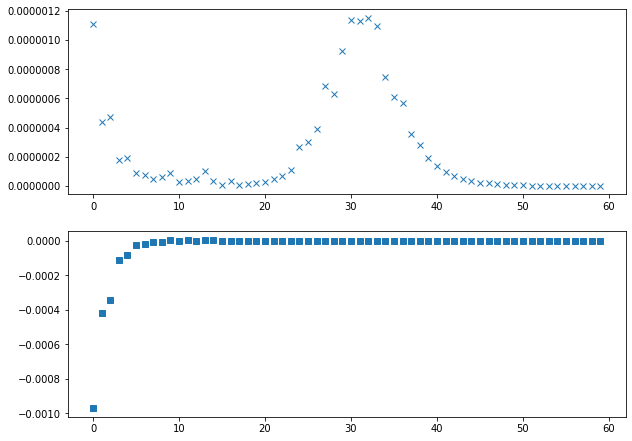

In [122]:
fig1 = plt.figure(figsize = main_figsize)
ax0 = fig1.add_subplot(211)
plt.plot(Sfm,'x')#,Num,'d')

fig1.add_subplot(212)
plt.plot(Num,'s')


Circuit string: R0-p(R1,C1)-p(R2,E2)
Fit: True

Initial guesses:
     R0 = 5.80e+01 [Ohm]
     R1 = 1.50e+01 [Ohm]
     C1 = 1.40e-06 [F]
     R2 = 1.60e+03 [Ohm]
   E2_0 = 2.23e-04 [Ohm^-1 sec^a]
   E2_1 = 9.50e-01 []

Fit parameters:
     R0 = 5.86e+01  (+/- 2.62e+00) [Ohm]
     R1 = 8.65e+00  (+/- 2.72e+00) [Ohm]
     C1 = 1.12e-06  (+/- 8.97e-07) [F]
     R2 = 1.54e+03  (+/- 4.07e+00) [Ohm]
   E2_0 = 3.06e-04  (+/- 1.49e-06) [Ohm^-1 sec^a]
   E2_1 = 7.16e-01  (+/- 2.42e-03) []



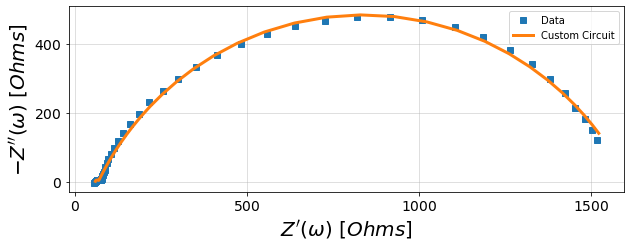

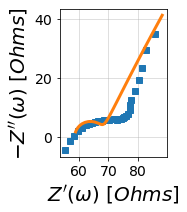

In [80]:
inits=[R_elyte,R_if,C_if,R_chem,C_chem,.95]
circ='R0-p(R1,C1)-p(R2,E2)'

FitCirc_Plot(circ, inits, freqs,Z) #,inset_len=20,save_figs=True,fig_name=r'Figures/1% OCV Circuit1 TESTTEST')


Circuit string: R0-p(R1,C1)-p(R2,E2)
Fit: True

Initial guesses:
     R0 = 5.80e+01 [Ohm]
     R1 = 1.50e+01 [Ohm]
     C1 = 1.40e-06 [F]
     R2 = 1.60e+03 [Ohm]
   E2_0 = 2.23e-04 [Ohm^-1 sec^a]
   E2_1 = 9.50e-01 []

Fit parameters:
     R0 = 5.86e+01  (+/- 2.62e+00) [Ohm]
     R1 = 8.65e+00  (+/- 2.72e+00) [Ohm]
     C1 = 1.12e-06  (+/- 8.97e-07) [F]
     R2 = 1.54e+03  (+/- 4.07e+00) [Ohm]
   E2_0 = 3.06e-04  (+/- 1.49e-06) [Ohm^-1 sec^a]
   E2_1 = 7.16e-01  (+/- 2.42e-03) []



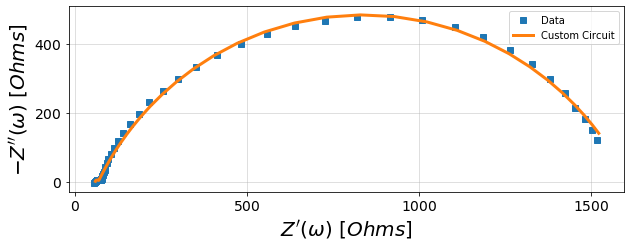

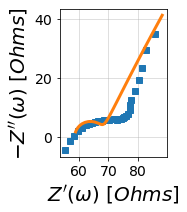

In [81]:
inits1=[R_elyte,R_if,C_if,R_chem,C_chem,.95]
circ1='R0-p(R1,C1)-p(R2,E2)'

FitCirc_Plot(circ1, inits1, freqs,Z,save_figs=False,fig_name=r'Figures/1% OCV Circuit1')


Circuit string: R0-p(R1,C1)-G1
Fit: True

Initial guesses:
     R0 = 5.80e+01 [Ohm]
     R1 = 1.50e+01 [Ohm]
     C1 = 1.40e-06 [F]
   G1_0 = 1.60e+03 [Ohm]
   G1_1 = 4.64e-01 [sec]

Fit parameters:
     R0 = 3.38e+01  (+/- 1.92e+00) [Ohm]
     R1 = 1.06e+01  (+/- 1.92e+00) [Ohm]
     C1 = 7.02e-24  (+/- 2.19e-07) [F]
   G1_0 = 1.45e+03  (+/- 9.23e+00) [Ohm]
   G1_1 = 8.39e-01  (+/- 1.81e-02) [sec]



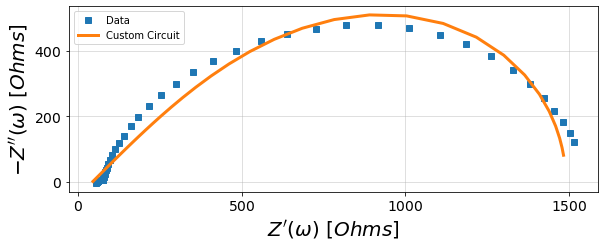

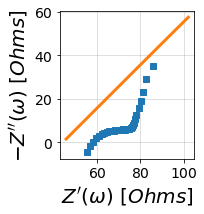

In [88]:
inits2=[R_elyte,R_if,C_if,Rg_init,tg_init]
circ2='R0-p(R1,C1)-G1'

FitCirc_Plot(circ2, inits2, freqs,Z,save_figs=False,fig_name=r'Figures/1% OCV Circuit2')


Circuit string: R0-p(C2,p(R1,C1)-G1)
Fit: True

Initial guesses:
     R0 = 5.80e+01 [Ohm]
     C2 = 2.90e-09 [F]
     R1 = 1.50e+01 [Ohm]
     C1 = 1.40e-06 [F]
   G1_0 = 1.60e+03 [Ohm]
   G1_1 = 4.64e-01 [sec]

Fit parameters:
     R0 = 6.37e+01  (+/- 4.32e+00) [Ohm]
     C2 = 1.90e-05  (+/- 4.42e-05) [F]
     R1 = 1.28e-10  (+/- 1.27e+02) [Ohm]
     C1 = 4.09e+01  (+/- 2.02e-13) [F]
   G1_0 = 1.42e+03  (+/- 1.29e+02) [Ohm]
   G1_1 = 7.62e-01  (+/- 7.37e-02) [sec]



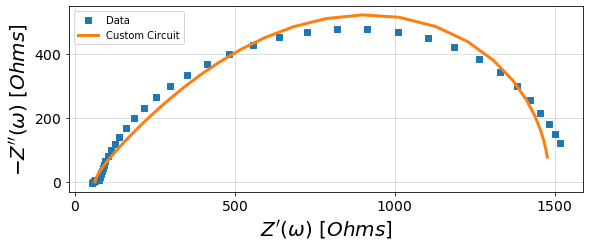

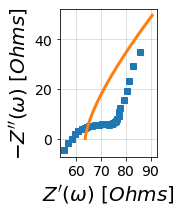

In [90]:
min_ind=np.argmin(np.imag(Z[:]))

inits3=[R_elyte,C_mask,R_if,C_if,Rg_init,tg_init]
circ3='R0-p(C2,p(R1,C1)-G1)'

FitCirc_Plot(circ3, inits3, freqs,Z,save_figs=False,fig_name=r'Figures/1% OCV Circuit3')


Circuit string: R0-p(E2,p(R1,C1)-G1)
Fit: True

Initial guesses:
     R0 = 5.80e+01 [Ohm]
   E2_0 = 2.90e-09 [Ohm^-1 sec^a]
   E2_1 = 9.50e-01 []
     R1 = 1.50e+01 [Ohm]
     C1 = 1.40e-06 [F]
   G1_0 = 1.60e+03 [Ohm]
   G1_1 = 4.64e-01 [sec]

Fit parameters:
     R0 = 6.37e+01  (+/- 4.91e+00) [Ohm]
   E2_0 = 1.90e-05  (+/- 6.02e-05) [Ohm^-1 sec^a]
   E2_1 = 1.00e+00  (+/- 1.94e-01) []
     R1 = 2.51e-14  (+/- 2.06e+02) [Ohm]
     C1 = 1.02e+02  (+/- 4.42e-13) [F]
   G1_0 = 1.42e+03  (+/- 2.12e+02) [Ohm]
   G1_1 = 7.62e-01  (+/- 7.93e-02) [sec]



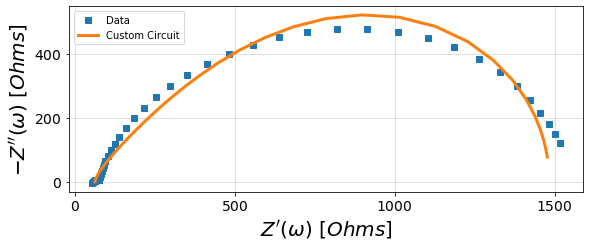

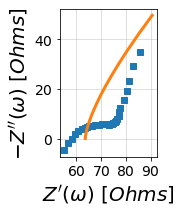

In [92]:
inits4=[R_elyte,C_mask,.95,R_if,C_if,Rg_init,tg_init]
circ4='R0-p(E2,p(R1,C1)-G1)'

FitCirc_Plot(circ4, inits4, freqs,Z,save_figs=False,fig_name=r'Figures/1% OCV Circuit4')


Circuit string: R0-p(C2,R2,p(R1,C1)-G1)
Fit: True

Initial guesses:
     R0 = 5.80e+01 [Ohm]
     C2 = 2.90e-09 [F]
     R2 = 1.05e+04 [Ohm]
     R1 = 1.50e+01 [Ohm]
     C1 = 1.40e-06 [F]
   G1_0 = 1.60e+03 [Ohm]
   G1_1 = 4.64e-01 [sec]

Fit parameters:
     R0 = 6.61e+01  (+/- 3.52e+00) [Ohm]
     C2 = 2.67e-05  (+/- 7.11e-06) [F]
     R2 = 8.25e+03  (+/- 7.95e+03) [Ohm]
     R1 = 4.53e+00  (+/- 6.19e+01) [Ohm]
     C1 = 1.08e-02  (+/- 1.36e-01) [F]
   G1_0 = 1.71e+03  (+/- 4.04e+02) [Ohm]
   G1_1 = 9.38e-01  (+/- 1.63e-01) [sec]



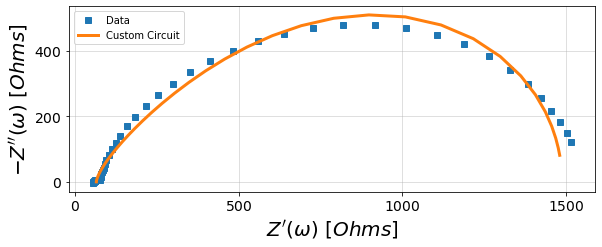

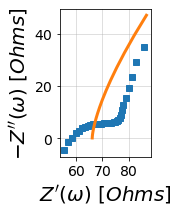

In [93]:
inits5=[R_elyte,C_mask,R_mask,R_if,C_if,Rg_init,tg_init]
circ5='R0-p(C2,R2,p(R1,C1)-G1)'

FitCirc_Plot(circ5, inits5, freqs,Z,save_figs=False,fig_name=r'Figures/1% OCV Circuit5')


Circuit string: R0-p(E2,R2,p(R1,C1)-G1)
Fit: True

Initial guesses:
     R0 = 5.80e+01 [Ohm]
   E2_0 = 2.90e-09 [Ohm^-1 sec^a]
   E2_1 = 8.00e-01 []
     R2 = 1.05e+04 [Ohm]
     R1 = 1.50e+01 [Ohm]
     C1 = 1.40e-06 [F]
   G1_0 = 1.60e+03 [Ohm]
   G1_1 = 4.64e-01 [sec]

Fit parameters:
     R0 = 6.57e+01  (+/- 1.32e+00) [Ohm]
   E2_0 = 3.03e-04  (+/- 7.69e-06) [Ohm^-1 sec^a]
   E2_1 = 7.15e-01  (+/- 1.60e-02) []
     R2 = 7.78e+03  (+/- 4.63e+05) [Ohm]
     R1 = 1.61e+01  (+/- 4.87e+02) [Ohm]
     C1 = 3.29e-02  (+/- 9.80e-01) [F]
   G1_0 = 1.91e+03  (+/- 2.77e+04) [Ohm]
   G1_1 = 3.87e-03  (+/- 5.97e-02) [sec]



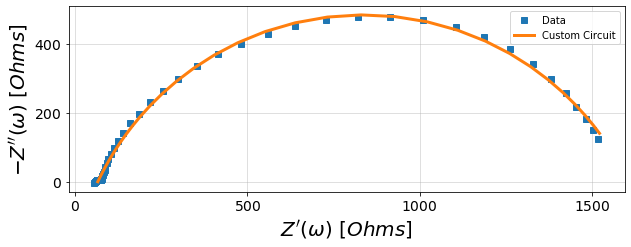

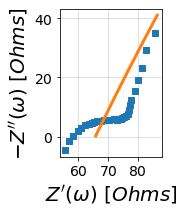

In [94]:
inits6=[R_elyte,C_mask,.8,R_mask,R_if,C_if,Rg_init,tg_init]
circ6='R0-p(E2,R2,p(R1,C1)-G1)'

FitCirc_Plot(circ6, inits6, freqs,Z,save_figs=False,fig_name=r'Figures/1% OCV Circuit6')

Simulating circuit based on initial parameters
Simulating circuit based on initial parameters
Simulating circuit based on initial parameters
Simulating circuit based on initial parameters


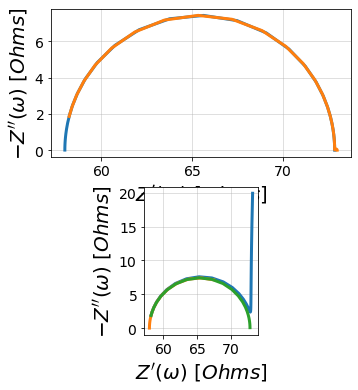

In [29]:
circuita=CustomCircuit(initial_guess=[R_elyte,R_if,C_if,R_chem,C_chem],circuit='R0-p(R1,C1)-p(R2,C2)')
Pred_a=circuita.predict(pred_freq,use_initial=True)

circuitb=CustomCircuit(initial_guess=[R_elyte,C_if,R_if,R_chem,C_chem],circuit='R0-p(C1,R1,p(R2,C2))')
Pred_b=circuitb.predict(pred_freq,use_initial=True)

circuitc=CustomCircuit(initial_guess=[R_elyte,C_if,R_if,R_chem,C_chem],circuit='R0-p(C1,R1,R2-C2)')
Pred_c=circuitc.predict(pred_freq,use_initial=True)

circuitd=CustomCircuit(initial_guess=[R_elyte,C_if,R_if,R_chem,C_chem],circuit='R0-p(C1,R1,p(R2,C2))')
Pred_s=circuitd.predict(pred_freq,use_initial=True)

fig=plt.figure(figsize=(6,6))
ax0=fig.add_subplot(211)
# plot_nyquist(ax0, pred_freq,Pred_a,fmt='-')
plot_nyquist(ax0, pred_freq,Pred_b,fmt='-')
plot_nyquist(ax0, pred_freq,Pred_c,fmt='-')

ax1=fig.add_subplot(212)

plot_nyquist(ax1, pred_freq,Pred_a[:30],fmt='-')
plot_nyquist(ax1, pred_freq,Pred_b[:30],fmt='-')
plot_nyquist(ax1, pred_freq,Pred_c[:30],fmt='-')


Circuit string: p(C2,p(R1,C1)-G1)
Fit: True

Initial guesses:
     C2 = 2.90e-09 [F]
     R1 = 1.50e+01 [Ohm]
     C1 = 1.40e-06 [F]
   G1_0 = 2.35e+03 [Ohm^-1 sec^1/2]
   G1_1 = 2.15e+00 [sec^-1]

Fit parameters:
     C2 = 1.66e-05  (+/- 3.89e-06) [F]
     R1 = 7.63e+00  (+/- 2.67e+01) [Ohm]
     C1 = 6.15e-03  (+/- 2.34e-02) [F]
   G1_0 = 1.61e+03  (+/- 5.47e+01) [Ohm^-1 sec^1/2]
   G1_1 = 1.29e+00  (+/- 5.11e-02) [sec^-1]



C:\Users\Modeling\Miniconda3\envs\impedance-analysis\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Modeling\Miniconda3\envs\impedance-analysis\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Modeling\Miniconda3\envs\impedance-analysis\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Modeling\Miniconda3\envs\impedance-analysis\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


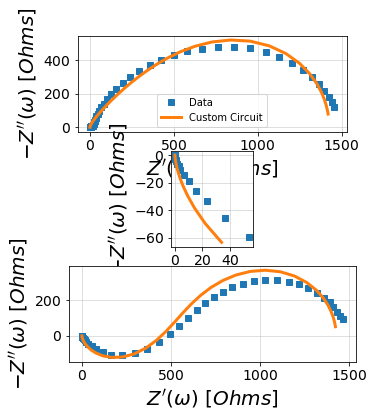

In [57]:
Z_corr=Z-Z[0]
inits=[C_mask,R_if,C_if,Y_init,K_init]
circ='p(C2,p(R1,C1)-G1)'

circuit7=CustomCircuit(initial_guess=inits,circuit=circ)
circuit7.fit(freqs,Z_corr)
print(circuit7)

pred_freq=np.logspace(np.log10(freqs[0]),np.log10(freqs[-1]),num=freqs.size)
custom_fit7=circuit7.predict(pred_freq)

C_Al=1e-4

fig=plt.figure(figsize=(6,6))
ax0=fig.add_subplot(311)
plot_nyquist(ax0, freqs, Z_corr,fmt='s')
plot_nyquist(ax0, pred_freq,custom_fit7,fmt='-')

ax1=fig.add_subplot(312)
plot_nyquist(ax1, freqs, 1/(1/Z_corr[:30]-(1j*2*np.pi*freqs[:30]*C_Al)),fmt='s')
plot_nyquist(ax1, pred_freq,1/(1/custom_fit7[:30]-(1j*2*np.pi*freqs[:30]*C_Al)),fmt='-')

ax2=fig.add_subplot(313)
plot_nyquist(ax2, freqs, 1/(1/Z_corr-(1j*2*np.pi*freqs*C_Al)),fmt='s')
plot_nyquist(ax2, pred_freq,1/(1/custom_fit7-(1j*2*np.pi*freqs*C_Al)),fmt='-')

ax0.legend(['Data','Custom Circuit'])

In [ ]:
#Berthier capacitance subtraction for Circuit 3. Z2=1/jwC

fig=plt.figure(figsize=(6,6))
ax0=fig.add_subplot(311)
plot_nyquist(ax0, freqs, Z_corr,fmt='s')
plot_nyquist(ax0, pred_freq,custom_fit7,fmt='-')

C_mask=3e-5
Z2=1/(1j*freqs*2*np.pi*C_mask)
Z_if=R_if/(1+1j*freqs*2*np.pi*R_if*C_if)

ax1=fig.add_subplot(312)
plot_nyquist(ax1, freqs, 1/(1/Z_corr-1/Z2),fmt='s')
plot_nyquist(ax1, pred_freq,1/(1/custom_fit7-1/Z2),fmt='-')

ax2=fig.add_subplot(313)
plot_nyquist(ax2, freqs, 1/(1/(Z_corr-Z_if)-1/Z2),fmt='s')
plot_nyquist(ax2, pred_freq,1/(1/(custom_fit7-Z_if)-1/Z2),fmt='-')

ax0.legend(['Data','Custom Circuit'])

In [ ]:
#Berthier capacitance subtraction for Circuit 5. Z2=R/(1+jwC)

fig=plt.figure(figsize=(6,6))
ax0=fig.add_subplot(311)
plot_nyquist(ax0, freqs, Z_corr,fmt='s')
plot_nyquist(ax0, pred_freq,custom_fit7,fmt='-')

C_mask=3e-5
R_mask2=R_mask*.1
Z2=R_mask/(1+1j*freqs*2*np.pi*R_mask*C_mask)
Z_if=R_if/(1+1j*freqs*2*np.pi*R_if*C_if)

ax1=fig.add_subplot(312)
plot_nyquist(ax1, freqs, 1/(1/Z_corr-1/Z2),fmt='s')
plot_nyquist(ax1, pred_freq,1/(1/custom_fit7-1/Z2),fmt='-')

ax2=fig.add_subplot(313)
plot_nyquist(ax2, freqs, 1/(1/(Z_corr-Z_if)-1/Z2),fmt='s')
plot_nyquist(ax2, pred_freq,1/(1/(custom_fit7-Z_if)-1/Z2),fmt='-')

ax0.legend(['Data','Custom Circuit'])

In [56]:
print(circuit3,circuit3.parameters_)


Circuit string: R0-p(C2,p(R1,C1)-G1)
Fit: True

Initial guesses:
     R0 = 5.80e+01 [Ohm]
     C2 = 2.90e-09 [F]
     R1 = 1.50e+01 [Ohm]
     C1 = 1.40e-06 [F]
   G1_0 = 2.35e+03 [Ohm^-1 sec^1/2]
   G1_1 = 2.15e+00 [sec^-1]

Fit parameters:
     R0 = 6.43e+01  (+/- 4.56e+00) [Ohm]
     C2 = 1.93e-05  (+/- 4.51e-05) [F]
     R1 = 3.90e-11  (+/- 1.30e+02) [Ohm]
     C1 = 4.93e+01  (+/- 4.98e-14) [F]
   G1_0 = 1.63e+03  (+/- 7.57e+01) [Ohm^-1 sec^1/2]
   G1_1 = 1.31e+00  (+/- 1.30e-01) [sec^-1]
 [6.42613899e+01 1.92508133e-05 3.90276094e-11 4.92556633e+01
 1.62616278e+03 1.31297652e+00]


Simulating circuit based on initial parameters
Simulating circuit based on initial parameters


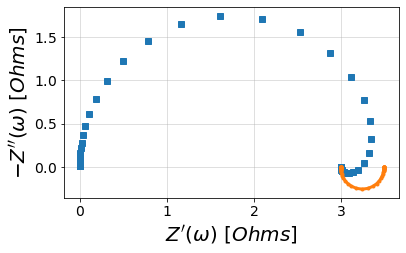

In [155]:
circ = 'p(C1,p(R1,R2-L1))'
circCorr = 'p(R1,R2-L1)'

vals = [1.4e-4, 3.5,21, 0.1225]
valsCorr = [3.5, 21, 0.1225]

pred_freq = np.logspace(np.log10(1e5), np.log10(1e-2), num = freqs.size)

BertCirc = CustomCircuit(circ, initial_guess = vals)
BC_pred = BertCirc.predict(pred_freq)

BertCircCorr = CustomCircuit(circCorr, initial_guess = valsCorr)
BCC_pred = BertCircCorr.predict(pred_freq)

fig=plt.figure(figsize=(6,6))
ax0=fig.add_subplot(111)
plot_nyquist(ax0, pred_freq, BC_pred,fmt='s')
plot_nyquist(ax0, pred_freq, BCC_pred)

In [146]:
pred_freq = np.logspace(np.log10(1e5), np.log10(1e-2), num = freqs.size)

In [154]:
def Sf(Y):
    a = np.diff(Y)
    b = np.diff(np.conj(Y))
    return np.sum(a*b)

def S(Y, Cdl, C, freq):
    w=2*np.pi*freq
    
    first = 2*(Cdl-C)*np.sum(np.diff(w)*np.diff(np.imag(Y)))
    second = (Cdl-C)**2*np.sum(np.diff(w**2))
    
    return Sf(Y)+first+second

In [153]:
Sf(1/BC_pred)

(1033.1169769684325+0j)

In [162]:
S(1/BC_pred, 1e-4, 9e-5, pred_freq)

(1141.22633796563+0j)

C:\Users\Modeling\Miniconda3\envs\impedance-analysis\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


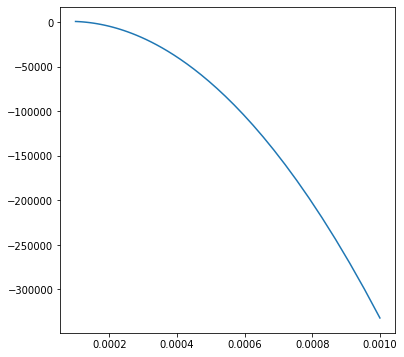

In [159]:
C_guess=np.logspace(-4,-3)

fig=plt.figure(figsize=(6,6))
ax0=fig.add_subplot(111)
plt.plot(C_guess, S(1/BC_pred, 1e-4, C_guess, pred_freq))


In [158]:
np.log10(C_guess)

array([-4.        , -3.97959184, -3.95918367, -3.93877551, -3.91836735,
       -3.89795918, -3.87755102, -3.85714286, -3.83673469, -3.81632653,
       -3.79591837, -3.7755102 , -3.75510204, -3.73469388, -3.71428571,
       -3.69387755, -3.67346939, -3.65306122, -3.63265306, -3.6122449 ,
       -3.59183673, -3.57142857, -3.55102041, -3.53061224, -3.51020408,
       -3.48979592, -3.46938776, -3.44897959, -3.42857143, -3.40816327,
       -3.3877551 , -3.36734694, -3.34693878, -3.32653061, -3.30612245,
       -3.28571429, -3.26530612, -3.24489796, -3.2244898 , -3.20408163,
       -3.18367347, -3.16326531, -3.14285714, -3.12244898, -3.10204082,
       -3.08163265, -3.06122449, -3.04081633, -3.02040816, -3.        ])